Finding the MRI brain tumor detection dataset

In [1]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np

print("Torch version:", torch.__version__)
print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)


Torch version: 2.9.0+cpu
NumPy version: 2.1.2
OpenCV version: 4.12.0


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


In [3]:
data_path = "brain_tumor_dataset"


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [5]:
dataset = datasets.ImageFolder(data_path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Dell/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


100.0%


In [7]:
vgg19.classifier[6] = nn.Linear(4096, 2)
vgg19 = vgg19.to(device)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19.parameters(), lr=0.0001)


VVG MODEL

In [9]:
epochs = 5

for epoch in range(epochs):
    vgg19.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg19(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")


Epoch 1/5, Loss: 0.6828, Accuracy: 64.36%
Epoch 2/5, Loss: 0.4206, Accuracy: 79.70%
Epoch 3/5, Loss: 0.2472, Accuracy: 89.60%
Epoch 4/5, Loss: 0.1806, Accuracy: 91.58%
Epoch 5/5, Loss: 0.1671, Accuracy: 93.07%


It is giving me this much Accuracy for unbalanced dataset of 253 images 


In [13]:
import os

yes_path = "brain_tumor_dataset/yes"
no_path  = "brain_tumor_dataset/no"

yes_count = len(os.listdir(yes_path))
no_count  = len(os.listdir(no_path))

print("Images with Tumor (yes):", yes_count)
print("Images without Tumor (no):", no_count)
print("Total Images:", yes_count + no_count)


Images with Tumor (yes): 155
Images without Tumor (no): 98
Total Images: 253


Trying to Make Dataset more balanced ...

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


ResNet-18

10× faster than VGG19

Accurate for medical images

Trains in 2–3 minutes

Works great on small datasets

In [15]:
from torchvision import models
import torch.nn as nn

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(512, 2)   # binary classification
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Dell/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace final fully connected layer for 2 classes
model.fc = nn.Linear(512, 2)

model = model.to(device)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [19]:
epochs = 6  # increase if dataset augmented

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | "
          f"Accuracy: {100 * correct / total:.2f}%")


Epoch 1/6 | Loss: 0.4003 | Accuracy: 81.68%
Epoch 2/6 | Loss: 0.1068 | Accuracy: 96.53%
Epoch 3/6 | Loss: 0.0327 | Accuracy: 100.00%
Epoch 4/6 | Loss: 0.0126 | Accuracy: 100.00%
Epoch 5/6 | Loss: 0.0122 | Accuracy: 100.00%
Epoch 6/6 | Loss: 0.0082 | Accuracy: 100.00%


Testing it(Evaluation on test set)

In [20]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 94.12%


Trying it on a single image 

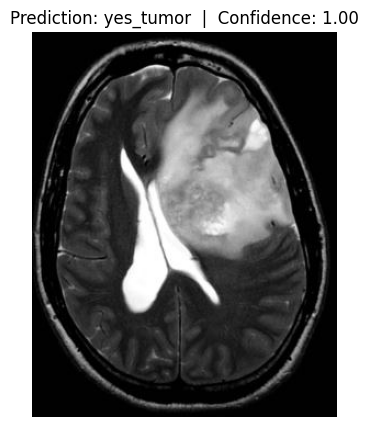

Class probabilities: [0.00211411 0.9978859 ]
Image tested: brain_tumor_dataset/yes\Y244.JPG


In [22]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn.functional as F

CLASSES = ["no_tumor", "yes_tumor"]

def predict_image(path, model, device="cpu"):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")

    # handle RGBA if exists
    if img.ndim == 3 and img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))

    # same normalization as training
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    x = tfm(img_resized).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = probs.argmax()

    return img, CLASSES[pred_idx], float(probs[pred_idx]), probs


# ============================
# ✅ Pick random YES image
# ============================
yes_folder = "brain_tumor_dataset/yes"
file = random.choice(os.listdir(yes_folder))
img_path = os.path.join(yes_folder, file)

img, label, conf, prob_list = predict_image(img_path, model, device)

# ============================
# ✅ Display image & prediction
# ============================
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {label}  |  Confidence: {conf:.2f}")
plt.show()

print("Class probabilities:", prob_list)
print("Image tested:", img_path)
